# Part 1: Understading the dataset

In [7]:
# df.shape

In [8]:
# df.info()

As we can see here even though we used here parse_dates Python stil sees 'Event dates' as object. 

To be honest I thought, looking at the column namings, there will be less 'object' type columns. 

We need to check what causes the problem and investigate values in the strange 'object' columns.

In [9]:
# df.describe()

As we can see there is nothing t`hat we can use. 

Let's dig deeper.

In [10]:
# df.head(5)

In [11]:
# df.columns

Quick fix here: daily I see tables where columns haves spaces instead of underscores or other signs so using lambda to treat columns as 'x' and then replacing in every 'x' space for underscore is a gamechanger!

In [12]:
# df['Year_of_event'].unique()

Here I decided to go only with ultramarathons that have taken place since 2000. 

I wasn't sure about the Athlete performance in earlier races so this is why. 

If you want to check races in given time code below:

In [13]:
# df_filtered = df[(df['Year_of_event'] >= 1800) & (df['Year_of_event'] <= 1900)]
# df_filtered.head()


At the time I didn't know here how to expand visible number of rows (even though I used pd.set_option('display.max_rows', None)) so had to find a different aproach ;) 

It's simple: for every 'i' which is a result of df['Event_distance/length'].unique() print 'i'.

You could also go with below code but for me it was more than enough.

# Step 2: Data Cleaning

In [14]:
import pandas as pd
from datetime import datetime

df = pd.read_csv('ultramarathon.csv', low_memory=False)
df = df.to_parquet('ultramarathon.parquet')

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from datetime import datetime
from datetime import timedelta

df = pd.read_parquet('ultramarathon.parquet')

df.rename(columns=lambda x: x.replace(' ', '_'), inplace=True)

#We dont need data before 1999
df_filtered = df[df['Year_of_event'] >= 2000]

df_filtered['length'] = df_filtered['Event_distance/length'].str[-2:]
df_filtered['length'] = df_filtered['length'].astype('string')

df_filtered = df_filtered[~df_filtered['length'].str.contains('d|h|en|p.')]
df_filtered = df_filtered[~df_filtered['Event_distance/length'].str.contains('stages|6:40|07:35|tapp')]

dict_for_formats = {'Event_dates': 'string', 'Event_distance/length': 'string', 'Event_name': 'string', 'Athlete_club': 'string','Athlete_country':'string',\
                            'Athlete_gender':'string', 'Athlete_age_category': 'string', 'Athlete_performance': 'string'}
df_filtered = df_filtered.astype(dict_for_formats)

df_filtered_2 = df_filtered.copy()

df_filtered_2 = df_filtered[['Year_of_event',
                            'Event_dates','Event_name', 'Event_distance/length','Athlete_performance',
                            'Athlete_country', 'Athlete_year_of_birth','Athlete_gender','Athlete_age_category', 'length']]

df_filtered_2 = df_filtered_2.rename(columns={'Athlete_year_of_birth': 'Age', 
                                 'Year_of_event':'Year',
                                 'Event_dates':'Date',
                                 'Event_name':'Event',
                                 'Event_distance/length':'Distance',
                                 'Athlete_performance':'Time',
                                 'Athlete_country':'Country',
                                 'Athlete_gender':'Gender'})

df_filtered_2['Date'] = df_filtered_2['Date'].str.replace('.*.-', '', regex=True)

# Example: specifying the format if your dates are in 'dd/mm/yyyy' format
df_filtered_2 = df_filtered_2.copy()
df_filtered_2['Date'] = pd.to_datetime(df_filtered_2['Date'], format='%d.%m.%Y', errors='coerce')

df_filtered_2['Distance'] = df_filtered_2['Distance'].str.rstrip()

df_filtered_2['Distance'] = df_filtered_2['Distance'].str.lower()


df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(',','.')

df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?mile\b', r'\1 mi', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?k\b', r'\1 km', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?m\b', r'\1 mi', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?miles\b', r'\1 mi', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace('+','')
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?mi\b', r'\1 mi', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace('100km split','100km')

df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace('4x52','208')
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace('112.km','112')
df_filtered_2['length'] = df_filtered_2['Distance'].str[-2:]
df_filtered_2['length'] = df_filtered_2['length'].astype('string')

df_filtered_2['Time'] = df_filtered_2['Time'].str.replace(r'(\d+)\s?h\b', r'\1', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?mi\b', r'\1', regex=True)
df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace(r'(\d+)\s?km\b', r'\1', regex=True)

df_filtered_2['Distance'] = df_filtered_2['Distance'].str.replace('229.100.100','229')
df_filtered_2 = df_filtered_2[~df_filtered_2['Time'].str.contains('0:00:00')]

df_filtered_2 = df_filtered_2[~df_filtered_2['Time'].str.contains('d')]

df_filtered_2['Time'] = pd.to_datetime(df_filtered_2['Time'], format='%H:%M:%S', errors='coerce').dt.time

df_filtered_2['Distance'] = df_filtered_2['Distance'].astype(float)

df_filtered_2['Distance'] = df_filtered_2['Distance'].round(0)

df_filtered_2['Distance'] = df_filtered_2['Distance'].astype(int)

df_filtered_2 = df_filtered_2[df_filtered_2['Time'].notna()]

# Define a custom function that performs the multiplication if needed
def adjust_distance(row):
    if row['length'] == 'mi':
        return row['Distance'] * 1.6
    else:
        return row['Distance']

# Apply this function across the DataFrame
df_filtered_2['Distance_in_km'] = df_filtered_2.apply(adjust_distance, axis=1)

df_filtered_2['Time_2'] = df_filtered_2['Time'].astype('string')

# Function to convert time format
def convert_time(time_str):
    # if pd.notna(time_str):
    #     time_str = time_str.strip().replace(' h', '')  # Remove extra characters
        try:
            # Parse time and reformat it
            return datetime.strptime(time_str, '%H:%M:%S').strftime('%H:%M:%S')
        except ValueError:
            try:
                # If the time is missing the hour part, add it
                return datetime.strptime(time_str, '%M:%S').strftime('00:%M:%S')
            except ValueError:
                # Handle other formats or return the original string
                return time_str
    # else:
    #     return time_str

# Apply the function to the column
df_filtered_2['Time_2'] = df_filtered_2['Time_2'].apply(convert_time)

# Convert 'Time' column to timedelta type
df_filtered_2['Time_2'] = df_filtered_2['Time_2'].astype('timedelta64[ns]')

# Convert 'Athlete_performance' from timedelta to total minutes
df_filtered_2['Total_minutes'] = df_filtered_2['Time_2'].dt.total_seconds() / 60

# Calculate pace as minutes per kilometer
df_filtered_2['Pace_min_per_km'] = df_filtered_2['Total_minutes'] / df_filtered_2['Distance']

df_filtered_2['Pace_min_per_km']  = df_filtered_2['Pace_min_per_km'].round(2)


df_filtered_2['Pace_min_per_km'] = df_filtered_2['Pace_min_per_km'].astype('string')

df_filtered_2['min_to_conv'] = df_filtered_2['Pace_min_per_km'].apply(lambda x: x.split('.')[1])

df_filtered_2['min_to_conv'] = '0.'+ df_filtered_2['min_to_conv']


df_filtered_2['min_to_conv'] = df_filtered_2['min_to_conv'].astype(float)*60

df_filtered_2['min_to_conv'] = df_filtered_2['min_to_conv'].astype('string')

df_filtered_2['min_to_conv'] = df_filtered_2['min_to_conv'].str.replace('.','')

df_filtered_2['Pace'] = df_filtered_2['Pace_min_per_km'].apply(lambda x: x.split('.')[0]) + '.' + df_filtered_2['min_to_conv'].astype('string')

df_filtered_2['Pace'] = df_filtered_2['Pace'].astype(float).round(2)

df_filtered_2 = df_filtered_2[(df_filtered_2['Pace'] >= 4.00) & (df_filtered_2['Pace'] <= 10.00)]

df_filtered_2 = df_filtered_2[(df_filtered_2['Distance_in_km'] >= 42.195)]

# df_filtered_2['Age'] = df_filtered_2['Year'] - df_filtered_2['Age']

# df_filtered_2 = df_filtered_2[(df_filtered_2['Age'] >= 18) & (df_filtered_2['Age'] <= 60)]

# df_filtered_2['Age'] = df_filtered_2['Age'].fillna(df_filtered_2['Age'].mean())

# df_filtered_2['Age'] = df_filtered_2['Age'].astype('int16')

df_filtered_2['Year'] = df_filtered_2['Year'].astype('int16')

df_filtered_2 = df_filtered_2.drop(columns=['Pace_min_per_km', 'min_to_conv', 'Total_minutes', 'Time_2', 'length', 'Distance', 'Age'])

df_filtered_2['Athlete_age_category'] = df_filtered_2['Athlete_age_category'].astype('category')
df_filtered_2['Gender'] = df_filtered_2['Gender'].astype('category')
df_filtered_2['Event'] = df_filtered_2['Event'].astype('category')
df_filtered_2['Country'] = df_filtered_2['Country'].astype('category')

df_filtered_2.reset_index(drop=True, inplace=True)

df_filtered_2.to_parquet('ultramarathons_clean.parquet', index=False)


/var/folders/z0/qrctxq5d6f51khdbp1n6z0zh0000gn/T/ipykernel_66459/2457026069.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['length'] = df_filtered['Event_distance/length'].str[-2:]
/var/folders/z0/qrctxq5d6f51khdbp1n6z0zh0000gn/T/ipykernel_66459/2457026069.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['length'] = df_filtered['length'].astype('string')


In [ ]:
df_filtered_2

,Year,Date,Event,Time,Country,Gender,Athlete_age_category,Distance_in_km,Pace
0,2018,2018-01-06,Selva Costera (CHI),04:51:39,CHI,M,M35,50.0,5.50
1,2018,2018-01-06,Selva Costera (CHI),05:15:45,CHI,M,M35,50.0,6.19
2,2018,2018-01-06,Selva Costera (CHI),05:16:44,CHI,M,M23,50.0,6.20
3,2018,2018-01-06,Selva Costera (CHI),05:34:13,ARG,M,M40,50.0,6.41
4,2018,2018-01-06,Selva Costera (CHI),05:54:14,CHI,M,M23,50.0,7.48
...,...,...,...,...,...,...,...,...,...
5583475,2015,2015-10-08,Yurrebilla Trail 56km Ultra (AUS),11:22:54,AUS,F,W40,56.0,12.11
5583476,2015,2015-10-08,Yurrebilla Trail 56km Ultra (AUS),11:26:25,AUS,M,M40,56.0,12.16
5583477,2015,2015-10-08,Yurrebilla Trail 56km Ultra (AUS),11:26:26,AUS,F,W40,56.0,12.16
5583478,2015,2015-10-08,Yurrebilla Trail 56km Ultra (AUS),11:27:25,AUS,F,W35,56.0,12.17


In [ ]:
df_csv = pd.read_csv('ultramarathons_clean.csv', low_memory=False)

df_csv = df_csv[:1_000_000]

df_csv.to_csv('ultramarathon_gpt.csv', index=False)

# Part 3: Data analytics

In [ ]:
df['Year'].value_counts()

In [ ]:
ax_bar_1 = df_filtered_2['Year'].value_counts() \
    .head(10) \
    .plot(kind='bar', title='Top 10 Years Amount of Athletes')
ax_bar_1.set_xlabel('Year')
ax_bar_1.set_ylabel('Count')

In [ ]:
print(df_filtered.columns)

In [ ]:
df_corr = df_filtered_2[['Distance_in_km','Pace']].dropna().corr()

df_corr

In [ ]:
import seaborn as sns

In [ ]:
sns.heatmap(df_corr, annot=True)

In [ ]:

df_corr_performance = df_filtered_2[['Time','Pace']].dropna().corr()
sns.heatmap(df_corr_performance, annot=True)

In [ ]:
import matplotlib.pyplot as plt

NameError: name 'plt' is not defined

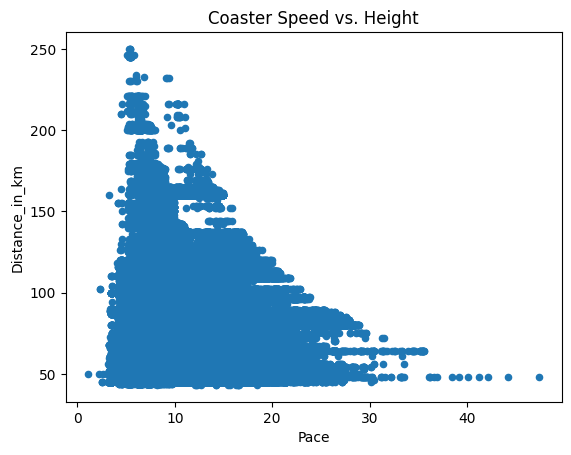

In [ ]:
df_filtered_2.plot(kind='scatter',
        x='Pace',
        y='Distance_in_km',
        title='Coaster Speed vs. Height')
plt.show()

In [ ]:
df_filtered_2['Pace'].min()

In [ ]:
print(df_filtered.columns)